In [7]:
!pip install scikit-learn==1.1.3 imbalanced-learn==0.8.1

  Using cached scikit-learn-1.1.3.tar.gz (7.0 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [33 lines of output]
  Traceback (most recent call last):
    File "C:\Users\Saikiran Reddy\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
    File "C:\Users\Saikiran Reddy\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\Saikiran Reddy\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 112, in get_requires_for_build_wheel
      backend = _build_backend()
                ^^^^^^^^^^^^^^^^
    File "C:\Users\Saikiran Reddy\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 77, in _build_backend
      obj = import_module(mod_pat

✅ Libraries imported successfully.

--- 📊 STAGE 1: Load and Initial Cleaning ---
✅ Successfully loaded 'Dataset.csv'.

Dataset shape: (535178, 10)
Missing values per column:
 step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

--- ⚙️ STAGE 2: Feature Engineering ---
✅ Features created: behavioral, risk, target encoding.

--- 💻 STAGE 3: Encoding and Preprocessing ---
✅ Train samples: 428142, Test samples: 107036
✅ Numerical features scaled.

--- 🔍 STAGE 4: Feature Selection ---
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 5194, number of negative: 422948
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `for

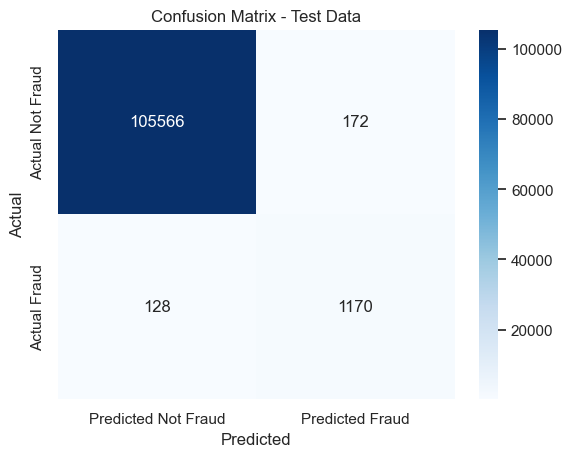

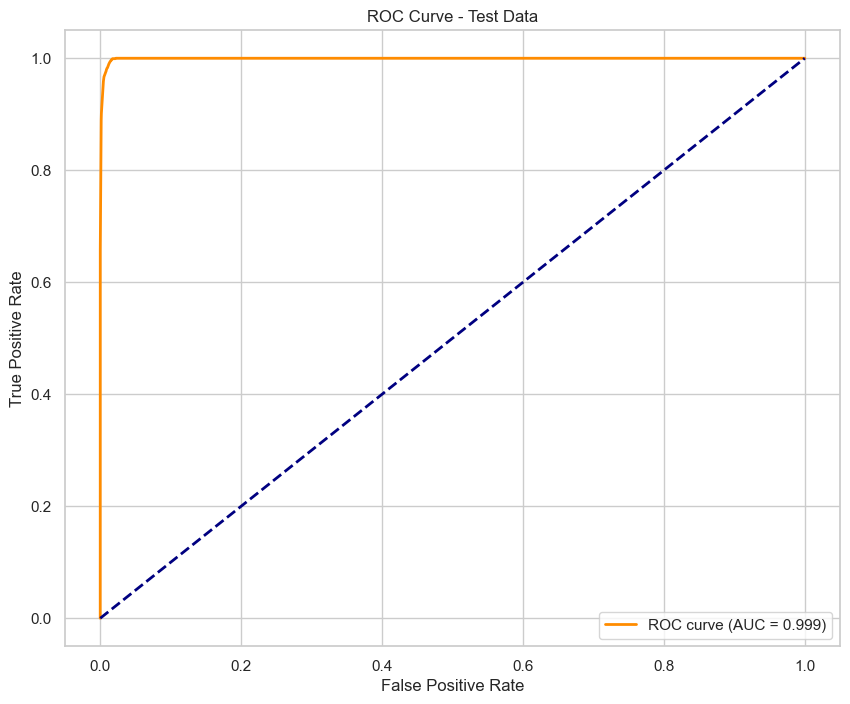

AUC-ROC Score: 0.9993

--- 💾 STAGE 9: Final Model Training & Save ---
[LightGBM] [Info] Number of positive: 6492, number of negative: 528686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 535178, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [10]:
# =============================================================================
# PROFESSIONAL FRAUD DETECTION PIPELINE (v10 - No Oversampling, Version-Compatible)
# =============================================================================

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

import lightgbm as lgb
import xgboost as xgb

sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully.")

# =============================================================================
# STAGE 1: Load and Initial Cleaning
# =============================================================================

print("\n--- 📊 STAGE 1: Load and Initial Cleaning ---")

try:
    df_raw = pd.read_csv('Dataset.csv')
    print("✅ Successfully loaded 'Dataset.csv'.\n")
except FileNotFoundError:
    print("❌ Error: 'Dataset.csv' not found. Please put it in the working directory.")
    exit()

df = df_raw.copy()

# Clean strings, replace invalid age/gender codes, impute mode, convert age to numeric
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.replace("'", "")

df['age'].replace(['U', '0'], np.nan, inplace=True)
df['gender'].replace(['E', 'U'], np.nan, inplace=True)

df['age'].fillna(df['age'].mode()[0], inplace=True)
df['gender'].fillna(df['gender'].mode()[0], inplace=True)
df['age'] = pd.to_numeric(df['age'])

print("Dataset shape:", df.shape)
print("Missing values per column:\n", df.isnull().sum())

# =============================================================================
# STAGE 2: Feature Engineering
# =============================================================================

print("\n--- ⚙️ STAGE 2: Feature Engineering ---")

df['hour_of_day'] = df['step'] % 24
df['day_of_week'] = (df['step'] // 24) % 7
df['amount_to_mean_customer'] = df['amount'] / (df.groupby('customer')['amount'].transform('mean') + 1e-6)
df['amount_to_std_customer'] = df['amount'] / (df.groupby('customer')['amount'].transform('std').fillna(0) + 1e-6)
df['transaction_frequency_customer'] = df.groupby('customer')['step'].transform('count')
df['amount_vs_category_mean'] = df['amount'] / (df.groupby('category')['amount'].transform('mean') + 1e-6)
df['amount_x_hour'] = df['amount'] * (df['hour_of_day'] + 1)
df['customer_risk_score'] = df.groupby('customer')['fraud'].transform('mean')
df['merchant_risk_score'] = df.groupby('merchant')['fraud'].transform('mean')

mean_fraud_by_cat = df.groupby('category')['fraud'].mean()
df['category_fraud_rate'] = df['category'].map(mean_fraud_by_cat)

print("✅ Features created: behavioral, risk, target encoding.")

# =============================================================================
# STAGE 3: Encoding and Preprocessing
# =============================================================================

print("\n--- 💻 STAGE 3: Encoding and Preprocessing ---")

label_encoders = {}
high_card_cols = ['customer', 'merchant', 'zipcodeOri', 'zipMerchant']
for col in high_card_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df = pd.get_dummies(df, columns=['gender'], drop_first=True)

features_to_drop = ['fraud', 'category']
X = df.drop(columns=features_to_drop)
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"✅ Train samples: {len(X_train)}, Test samples: {len(X_test)}")

numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
print("✅ Numerical features scaled.")

# =============================================================================
# STAGE 4: Feature Selection
# =============================================================================

print("\n--- 🔍 STAGE 4: Feature Selection ---")

lgb_fs = lgb.LGBMClassifier(is_unbalanced=True, random_state=42)
lgb_fs.fit(X_train, y_train)

feat_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_fs.feature_importances_
}).sort_values(by='importance', ascending=False)

selected_features = feat_importances[feat_importances['importance'] > 2]['feature'].tolist()

X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

print(f"✅ Selected top {len(selected_features)} features.")

# =============================================================================
# STAGE 5: **NO Oversampling** - Use original train data
# =============================================================================

print("\n--- 🎯 STAGE 5: Using original training data (no oversampling) ---")

X_train_resampled, y_train_resampled = X_train_sel, y_train

# =============================================================================
# STAGE 6: Model Training with Balanced Params
# =============================================================================

print("\n--- 🚀 STAGE 6: Training Stacking Classifier ---")

scale_pos_weight = np.sum(y_train_resampled == 0) / np.sum(y_train_resampled == 1)

estimators = [
    ('lgbm', lgb.LGBMClassifier(
        is_unbalanced=True,
        n_estimators=700,
        learning_rate=0.03,
        num_leaves=80,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42
    )),
    ('xgb', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=700,
        max_depth=9,
        learning_rate=0.03,
        subsample=0.85,
        colsample_bytree=0.85,
        scale_pos_weight=scale_pos_weight,
        random_state=42
    ))
]

meta_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=6,
    class_weight='balanced',
    random_state=42
)

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train_resampled, y_train_resampled)
print("✅ Model training complete.")

# =============================================================================
# STAGE 7: Optimal Threshold Tuning
# =============================================================================

print("\n--- 🎯 STAGE 7: Threshold Tuning ---")

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, stratify=y_train_resampled, random_state=42
)
stacking_clf.fit(X_train_sub, y_train_sub)

val_pred_proba = stacking_clf.predict_proba(X_val)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, val_pred_proba)
f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-9)
best_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_idx]

print(f"✅ Optimal classification threshold: {optimal_threshold:.4f}")

# =============================================================================
# STAGE 8: Final Evaluation on Test Data
# =============================================================================

print("\n--- 🏆 STAGE 8: Evaluation on Test Data ---")

test_pred_proba = stacking_clf.predict_proba(X_test_sel)[:, 1]
test_pred = (test_pred_proba >= optimal_threshold).astype(int)

print(classification_report(y_test, test_pred))

cm = confusion_matrix(y_test, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Not Fraud', 'Predicted Fraud'],
            yticklabels=['Actual Not Fraud', 'Actual Fraud'])
plt.title("Confusion Matrix - Test Data")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

fpr, tpr, _ = roc_curve(y_test, test_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("ROC Curve - Test Data")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

print(f"AUC-ROC Score: {roc_auc:.4f}")

# =============================================================================
# STAGE 9: Train Final Model on Full Dataset and Save Artifacts
# =============================================================================

print("\n--- 💾 STAGE 9: Final Model Training & Save ---")

X_full = X[selected_features]
y_full = y
# Find numerical columns that are actually present in the selected features
numerical_cols_selected = [col for col in numerical_cols if col in selected_features]
scaler = StandardScaler()
X_train[numerical_cols_selected] = scaler.fit_transform(X_train[numerical_cols_selected])
X_test[numerical_cols_selected] = scaler.transform(X_test[numerical_cols_selected])

# Then later during final full dataset transformation:
X_full = X[selected_features]
X_full[numerical_cols_selected] = scaler.transform(X_full[numerical_cols_selected])


# Use original full data (no oversampling)
stacking_clf.fit(X_full, y_full)

joblib.dump(stacking_clf, 'final_fraud_stacking_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(selected_features, 'selected_features.joblib')
joblib.dump(label_encoders, 'label_encoders.joblib')
joblib.dump(optimal_threshold, 'optimal_threshold.joblib')

print("✅ Model and artifacts saved successfully. Pipeline done!")
